[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MobleyLab/drug-computing/blob/master/uci-pharmsci/assignments/3D_structure_shape/3D_structure_shape_assignment.ipynb)

# 3D Structure/Shape Assignment

### Submission by AK Nandkeolyar

## Overview

This assignment involves two major parts. It first introduces the OEChem toolkits by having you perform some simple tasks with molecules in two and three dimensions, including generating 3D structures of molecules (much of which you will have already seen in the 3D structure/shape lecture and Jupyter notebook). You will also convert between common file formats and do simple shape overlays as well as visualization of your molecules. Some software installation will be required.

In the second major part of this assignment, you will use shape overlays to try and recognize HIV integrase inhibitors from a small library of potential HIV integrase inhibitors.

## More detailed overview

This assignment works through common tasks for working with small molecules. Specifically, you want to model a molecule, and you need to build 2D and 3D structures of the molecule, save to a particular file format for visualization, and compare it to other molecules. Here, you get to do these for the first time. Many different tool sets do these tasks, but here I’ll introduce you to one particular tool set (from OpenEye software) that works particularly well with Python and is free to academics. You have already seen and used this set of tools in class in the 3D structure/shape Jupyter notebook. This assignment will simply build on that notebook. Especially, Step 0 through Step 3 replicate tasks done in that notebook.


After completing these initial tasks, you will then take a small library of potential HIV integrase inhibitors, and use a shape-based search to try and identify active compounds on the basis of shape similarity to known inhibitors.

In [133]:
from openeye.oechem import *
from openeye.oeiupac import *
from openeye.oeomega import *
from openeye.oeshape import *
from openeye.oedepict import *
import openeye.oedepict as oedepict
import pandas as pd
import matplotlib.pyplot as plt
import operator
import numpy as np
from sklearn import metrics

# Getting started/warm-up

Before getting started, make a copy of this Jupyter notebook to work in and name it something else, such as `Mobley_3D_structure_shape.ipynb` if your last name is Mobley.

***If you are running this on Google Colab, please add the installation blocks from the [getting started notebook](https://github.com/MobleyLab/drug-computing/blob/master/uci-pharmsci/Getting_Started.ipynb) or [condacolab](https://github.com/aakankschit/drug-computing/blob/master/uci-pharmsci/Getting_Started_condacolab.ipynb) here and then execute the code below***

## Step 0: Install PyMol for visualization

We've seen `nglview` already for interactive visualization, but it is not as useful for visualizing things which are neither (a) MD simulations, nor (b) single structures. Specifically, here we will generate multiple structures/conformations, so we need a bit better visualization.

In this exercise, we’ll begin looking at and working with molecules in 3D, which means we need a viewer. PyMol is a popular general purpose one we will use extensively in this class. You should obtain the free academic version of PyMol online, but if you have any trouble with that please contact me. Alternate viewers like VMD or Chimera could also be used, but here I'll explain PyMol's usage.

## Step 1: Build 2D structures of some molecules

The first step is to build some molecules to work with. You might need to do this because your boss or research adviser asks you to model certain molecules, or you might come across some 2D structures of molecules in a research paper you would like to model. In any case, for whatever reason, you have a list of molecules to model, and you need to start by building their structures.

Let’s start by building 2D structures. If you already have commercial or favorite software for this, like ChemDraw, feel free to use that. If not, I recommend Marvin, which is free, as noted in the 3D structure/shape lecture. You can use it [within your browser](https://marvinjs-demo.chemaxon.com/latest/); you may need to install a free Java plugin to do so) or [download it](https://www.chemaxon.com/products/marvin/marvinsketch/) and install it on your computer (http://www.chemaxon.com/download/marvin/for-end-users/). I normally use the desktop version. 

In Marvin, draw some structures of molecules (if you have some molecules you’re interested in because of another class or research, you should do them, otherwise just pick some) and save them to your computer (from the file->save as menu) as MDL SDF files, one at a time. 

Drawing them should produce something like this:
![image](https://raw.githubusercontent.com/MobleyLab/drug-computing/master/uci-pharmsci/lectures/3D_structure_shape/Marvin_molecule.png)

Use the buttons at the bottom to create pre-formed rings; the tools at right can be used to select specific bond types or stereochemistry, and the buttons at right can be used to introduce elements other than carbon.

You should select at least 5-10 molecules to build, of your choice. Try to include some which are relatively similar to one another (i.e. differing only by a functional group, for example) and some which are not.
	Once your molecules are built, I suggest loading them (or at least one) in PyMol (open PyMol, then go to File->Open, then select your file) and having a quick look. You should see something like the below, though obviously details will depend on your platform (OS X, Linux, Windows) and what you’ve named your molecules. I suggest clicking the “show” button (S, as indicated by the red arrow) and choosing the “sticks” representation so you can see your molecule more clearly. Try clicking it and dragging to rotate -- notice how the molecule is completely planar (two dimensional) right now, even though it shouldn’t be. If you would like, you can choose Display -> Show Valences to show bond types. Experiment with using S to show other representations (such as surface) if you like, and use H to hide representations you’re done with.
    
![pymol](https://github.com/MobleyLab/drug-computing/blob/master/uci-pharmsci/assignments/3D_structure_shape/pymol.png?raw=1)

## Step 2: Building 3D structures of molecules

In the next step, you will want to build 3D structures of your molecules. I have provided some example Python code for this (and for other tasks) in the [`3D_Structure_shape.ipynb`](https://github.com/MobleyLab/drug-computing/blob/master/uci-pharmsci/lectures/3D_structure_shape/3D_Structure_Shape.ipynb) notebook we used in the relevant lecture.  

### First, do this for just one molecule

**Put some code in the box just below to read in one of the molecules you drew and saved from the SDF file, generate a 3D conformation, and write it out to a mol2 file**, drawing on the examples from the lecture.

In [1]:
!ls

3D_structure_shape_assignment.ipynb docking.ipynb
3NF8_ligand.pdb                     final_clean_binders.txt
SAMPL8_1.sdf                        fitted_output.mol2
SAMPL8_2.sdf                        pymol.png
SAMPL8_3.sdf                        ranks.md
SAMPL8_6.sdf                        test.mol2
actual_w_maybridge.txt              test.sdf


In [ ]:
istream = oemolistream('SAMPL8_1.sdf')
mol2 = OEMol()
OEReadMolecule(istream,mol2)
istream.close()

### But we're going to want to do this for many molecules, so write some functions

Here let's write functions to read molecules, write molecules, and generate conformations; we'll call the last one `expandConformations` because it could be used on a molecule which already has one conformation in order to generate many conformations, as well.

We'll make these functions so you can easily reuse them on many molecules.

I've written the documentation strings for you in the code below; your job is to fill in the inner workings and then make sure they work

#### Write your functions here

In [136]:
def readMolecule( inputfile ):
    """Take specified input molecule file with an OEChem supported molecular file format. Read a molecule from the file and return it as an OEChem OEMol molecule."""

    #Insert your code (as seen in the example) here to read the input file 'inputfile'
    istream = oemolistream(inputfile)
    oemol = OEMol()
    OEReadMolecule(istream,oemol)
    istream.close()

    return oemol #Replace oemol with the name of your molecule object


def writeMolecule( oemol, outputfile):
    ostream = oemolostream(outputfile)
    OEWriteMolecule(ostream,oemol)
    ostream.close()
    """Write a provided oemol to specified output file using an OEChem supported file format, as determined by the file extension (such as .mol2 or .sdf).
Arguments:
- oemol: OEMol molecule to write
- outputfile: File to write to.
Returns: Nothing"""

    #Insert your code (as seen in the example) here to write an output file

def expandConformations( oemol, maxconfs = 100, strictStereo = False ):
    omega = OEOmega()
    omega.SetMaxConfs(maxconfs)
    omega.SetStrictStereo(strictStereo)
    expanded_oemol = OEMol(oemol)
    omega(expanded_oemol)
    """Take a provided OEMol molecule, and use OpenEye's Omega to generate multiple conformations of the molecule, which are then returned in a new OEMol molecule.
Arguments:
- oemol: Provided molecule to generate conformations for
- maxconfs: Optional argument (default 100) specifying the maximum number of conformations to generate. Specify 1 to get just a single conformation.
- strictStereo: Optional argument specifying whether (True) or not (False) to use strict stereochemistry checking for Omega. Default: True.
Returns:
- expanded_oemol: OEMol containing the generated conformations."""

    #Write your code here (as seen in the example)
    return expanded_oemol

#### You probably want to test your functions now
You should probably use the box below to make sure you can read in one of the molecules you created, generate conformations, and write it back out again. If you've written your functions properly, this code should just work!

In [139]:
inputfile = 'test.sdf' # A test molecule I provided

mol = readMolecule(inputfile)
expandedmol = expandConformations( mol ) 
writeMolecule(expandedmol,'test.mol2') #Write out to a mol2 file

In [151]:
import py3Dmol
viewer = py3Dmol.view(data=open('test.mol2','r').read(),style={'stick':{}})
viewer.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Now you should probably check with PyMol that `test.mol2` has a molecule with a 3D conformer in it, or add visualization in this notebook using `nglview` to check.

## Step 3: Shape overlay your molecules

### Get ready
Next, we want to do a shape overlay of your molecules so we can see how structurally similar they are. This is a common task in drug discovery, as we noted in class, and often can be used in several ways, such as finding out about the likely shape of a binding site based on the molecules which bind there, or finding new molecules which may fit a binding site while being chemically distinct from existing molecules based on their shape. 

Here, our goal will be to take your entire set of molecules and overlay them onto a common reference structure. Here's an example which does a shape (+color, where color basically measures chemical similarity) overlay for a pair of molecules; this is rather likewhat you saw in the 3D structure/shape lecture: 

In [17]:
from openeye.oechem import *
from openeye.oeomega import *
from openeye.oeiupac import *
from openeye.oeshape import *

omega = OEOmega() #Initialize class
omega.SetMaxConfs(100) #Here we want to use more conformers if needed
omega.SetStrictStereo(False) #Set to false to pick random stereoisomer if stereochemistry is not specified

# Make some molecules
ibuprofen = OEMol()
naproxen = OEMol()
OEParseIUPACName(ibuprofen, 'ibuprofen')
OEParseIUPACName(naproxen, 'naproxen')

#Set up reference molecule
refmol = ibuprofen
omega(refmol)

#Fit molecule
fitmol = naproxen
omega(fitmol)
fitmol.SetTitle('naproxen')

# Open output stream for output molecule
outfs = oemolostream('fitted_output.mol2')
# How many conformers will we generate for fitting?
nconfs = 10

# Setup ROCS to provide specified number of conformers per hit
options = OEROCSOptions()
options.SetNumBestHits(nconfs)
options.SetConfsPerHit(nconfs)
rocs = OEROCS(options)
rocs.AddMolecule(fitmol) #Add our molecule as the one we are fitting

# Loop over results and output
for res in rocs.Overlay(refmol):
    outmol = res.GetOverlayConfs() #Use GetOverlayConf to get just the best; GetOverlayConfs for all
    OERemoveColorAtoms(outmol)
    OEAddExplicitHydrogens(outmol)
    OEWriteMolecule(outfs, outmol)
    print("title: %s  tanimoto combo = %.2f" % (outmol.GetTitle(), res.GetTanimotoCombo()))
outfs.close()

# If you wanted, you could also print just the "color" similarity:
#print(res.GetColorTanimoto())
# Or just the shape similarity:
#print(res.GetShapeTanimoto())

title: naproxen_12  tanimoto combo = 1.49
title: naproxen_9  tanimoto combo = 1.49
title: naproxen_12  tanimoto combo = 1.42
title: naproxen_13  tanimoto combo = 1.42
title: naproxen_7  tanimoto combo = 1.41
title: naproxen_4  tanimoto combo = 1.41
title: naproxen_4  tanimoto combo = 1.41
title: naproxen_8  tanimoto combo = 1.40
title: naproxen_0  tanimoto combo = 1.40
title: naproxen_12  tanimoto combo = 1.39


### Make a function to do this

Again, we'd be better off with a function to do this (and we'll use this function also below in the ligand-based design portion of the assignment, below). So, edit the code below and complete the `fitMoleculeToReference` function. The idea of this function is to take two molecules and compare them based on shape. The code here is a little complicated (which is why I’ve written similar code for you) and the only things you should have to change are the variable names and the indentation. What this ultimately will do is take two molecules, overlay them in a number of different ways, and then return (give back to the user) the actual overlays of the molecules, sorted from best to worst, and the “Tanimoto” scores of the overlays in the same order. Tanimoto scores are scores running from 0 to 1 and essentially measure similarity, where 0 means totally dissimilar and 1 means totally identical. Here, we are actually combining TWO Tanimoto scores (a ‘shape’ Tanimoto score and a ‘color’ (Chemistry) tanimoto score) so our overall Tanimoto score runs from 0 to 2.

Once you think you’ve got your `fitMoleculeToReference` function working, test it on a specific pair of molecules, then use `writeMolecule` (as above) to write out the reference molecule and the fitted molecule (to .mol2 or .sdf format) and view them in PyMol (after downloading to your computer) to ensure it’s working.

When you have the function working, then set up a loop over all of your molecules except your chosen reference molecule, ‘molecule1’, to overlay all of the molecules onto it. Before the loop, set up a list to store the best score for each pair of molecules. Inside the loop, fit each molecule onto the reference and then store the resulting fits to files (being careful not to overwrite any of your existing files). Also store the best score to the list of scores. Also have your program print out the scores. Visualize in PyMol the resulting overlays, and note which ones seem good, which ones seem bad, and which ones seem OK. Note whether these observations seem consistent with the scores (Tanimoto scores) you’re getting or not.

For this portion of the assignment, you should submit your reference molecule’s structure (.mol2 or .sdf) as well as the structure of the best overlay you found, with its score. You should also include a sentence or more explaining what you found in this step in your e-mail.

In [152]:
def fitMoleculeToReference( refmol, fitmol, ShapeColor = True):
    """Take a multi-conformation molecule to be fitted, and fit it onto a reference molecule using shape overlays.
Arguments:
- refmol: Reference molecule to fit onto
- fitmol: Molecule to fit onto the reference molecule; should be multiple-conformation
- ShapeColor: Optional argument specifying whether to score overlays based on shape alone (False) or to score based on both shape and color fit (True); in the latter case scores will run from 0 to 2 while in the former they will run from 0 to 1. Default: True.
Returns:
- fitted: The fitted conformations, ordered by score from best to worst
- tanimotos: Tanimoto scores of the fitted conformations."""

    #Write your code here, as seen in the example
    #fitmol.SetTitle('Fitted_Conformer_No')
    
    #outfs = oemolostream('fitted_output.mol2')
    nconfs=10
    options = OEROCSOptions()
    options.SetNumBestHits(nconfs)
    options.SetConfsPerHit(nconfs)
    rocs = OEROCS (options)
    rocs.AddMolecule(fitmol)
    
    fitted=[]
    tanimotos = []
    
    for res in rocs.Overlay(refmol):
        outmol = res.GetOverlayConfs()
        OERemoveColorAtoms(outmol)
        OEAddExplicitHydrogens(outmol)
        OEWriteMolecule(outfs,outmol)
        fitted.append(outmol.GetTitle())
        if ShapeColor==True:
            tanimotos.append(res.GetTanimotoCombo())
        else:
            tanimotos.append(res.GetShapeTanimoto())
                

    return (fitted, tanimotos)

In [153]:
## Testing Function
fit_mol_list = ['SAMPL8_2.sdf','SAMPL8_3.sdf','SAMPL8_6.sdf']
fitted_list=[]
tanimoto_list=[]
ref = expandConformations(readMolecule('SAMPL8_1.sdf'))

for fit_mol in fit_mol_list:
    fit = expandConformations(readMolecule(fit_mol))
    ## Naming Output Stream
    mol_name = fit_mol.split('.')[0]+'.mol2'
    writeMolecule(fit,mol_name)
    f,t = fitMoleculeToReference(ref,fit)
    fitted_list.append(mol_name)
    tanimoto_list.append(max(t))
dt = pd.DataFrame()
dt['Molecule_Name'] = fitted_list
dt['Tanimoto_Scores']= tanimoto_list
print(dt)

   Molecule_Name  Tanimoto_Scores
0  SAMPL8_2.mol2         1.198513
1  SAMPL8_3.mol2         1.231632
2  SAMPL8_6.mol2         1.091667


In [36]:
id_max = tanimoto_list.index(max(tanimoto_list))
print('The best fit molecule is %s' % (fitted_list[id_max].split('.')[0]))

The best fit molecule is SAMPL8_3


As can from the table above code cells SAMPL3 would seem to have the greatest similarity score amongst all of the tested molecules.

## Step 4: Ligand-based design

Your next step involves a simple application of this shape overlay technique to a real problem. You will take an existing ligand -- an HIV-1 integrase inhibitor -- from a structure the protein data bank (PDB) and compare this to a set of molecules which were tested experimentally for possible HIV integrase inhibition. The idea is to see whether the molecules which actually are HIV integrase inhibitors are among those which are most shape similar to the known inhibitor. 

Here, our exact plan is to take an existing list of 600-700 compounds which were tested for their ability to inhibit HIV-1 integrase. The 3NF8 structure in the PDB gives the crystal structure of one integrase inhibitor from this series bound to HIV-1 integrase. We will use the ligand from that structure as a query, or reference molecule, to see if it easily allows us to recognize other molecules which are likely to bind from our larger set of 600-700 compounds. This somewhat echoes the SAMPL4 HIV integrase challenge reported in [this paper]( http://link.springer.com/article/10.1007/s10822-014-9723-5), though the set of inactive compounds has been expanded somewhat by addition of a portion of the Maybridge fragment library which was also tested experimentally.

You will find several supporting files in this directory to help with this part of the assignment:
- `actual_w_maybridge.txt`: List of compounds actually tested
- `3NF8_ligand.pdb`: To simplify your life, I downloaded the 3NF8 structure and extracted the ligand of interest from it to serve as your reference molecule.
- `final_clean_binders.txt`: “Answers” — a text file which can be parsed (by code provided below) into a list of names of binders, which can be used to check your results.
Here is what you should do to complete the assignment, starting from the code provided below and the functions you wrote for in Steps 1-3 above:

- Set up a loop over the molecules in the set
- For every molecule, generate a 3D conformation with your `expandConformations` function, using `strictStereo` set to False (a few molecules have unspecified stereochemistry, and setting this to false here will cause OEChem to pick a random stereoisomer in such cases, which is acceptable in this test)
- Use your `fitMolToReference` function to overlay your molecule/conformations onto the reference molecule. Do this twice (getting back two different sets of output) — once with ShapeColor = False and once with it True, so we can compare and find out which works better here.
- Store your scores (I store them to a dictionary keyed by molecule name) in a way which allows you to track which molecules they correspond to. 
- Sort your molecule names by score (for each of the two sets of scores you have). I give an example of how to sort below.
- Compare your list of molecule names sorted by score with the list of actual binders (see code below) and identify where you find the actual binders. What you want to track at this stage is how many binders you find at or before each *rank* (entry number) in the list of sorted scores. For example, if there are 60 binders distributed across 650 molecules, you might find the first binder at the top of the list, the second binder at entry number 5, and the third binder at entry number 10. For every entry in the sorted list, store the number of binders found — so in this example, your first 10 entries would be `[ 1, 1, 1, 1, 2, 2, 2, 2, 2, 3]`. If this is still confusing, [see here](ranks.md) for a little more about this process.
- For each list of number of compounds found by rank (do this twice, once for each of your two sets of scores), convert it to a list of fraction of actual binders found by rank, by dividing each entry by the total number of binders in the set. For example, if you have found one binder and there are 60 in total, the fracion actives found is 1/60.
- Plot the fraction of binders found at each rank, versus the rank, for each of your two scoring schemes. This is an "enrichment plot".
- Also plot what would be expected if you picked compounds to call "active" at random. (Hint, in this approach you would expect to find no actives at rank 0, and all of the actives at rank N, with the fraction of actives found increasing linearly in between). This will allow you to determine whether your approach is doing better than random at recognizing likely active compounds.

### Some code to get you started

This shows how to read in the potential ligands, the reference molecule, and the actual binders.

In [146]:
from openeye.oechem import *
from openeye.oeiupac import *
from openeye.oequacpac import *
import pickle

# Load the text file containing all the potential ligands
file = open('actual_w_maybridge.txt', 'r')
text = file.readlines()
file.close()

#Generate OEMols for all of the potential ligands in our test set; store them to a dictionary by their compound name.
mol_by_name = {}
for line in text:
    mol = OEMol()
    tmp = line.split()
    name=tmp[0]
    smiles=tmp[1]
    parsed = OEParseSmiles(mol, smiles)
    if not parsed:
        print("Warning, could not parse %s, pausing." % name)
        raw_input()
    mol_by_name[name] = mol
    
#Load reference molecule which we will ultimately overlay onto
istream = oemolistream('3NF8_ligand.pdb')
refmol = OEMol()
OEReadMolecule( istream, refmol)
istream.close()

#Standardize protonation state and make sure there are explicit hydrogens
OE3DToInternalStereo(refmol)
OESetNeutralpHModel(refmol)
OEAddExplicitHydrogens(refmol)


#For the purposes of telling how we did, load a list of the names of actual binders
#Load actual binders
file = open('final_clean_binders.txt', 'r')
text = file.readlines()
file.close()
binders = [ line.split()[0].split('_')[0] for line in text]

### Tanimoto Scoring by Shape and Color

Generates enrichment scores utilizing tanimoto scores based on both shape and color

In [46]:
tanimoto4 = {}
ref_mol_expanded = expandConformations(refmol)
for key in mol_by_name:
    fit = expandConformations(mol_by_name[key])
    _,t = fitMoleculeToReference(ref_mol_expanded,fit)
    tanimoto4[key]=max(t)

#### Sorting Scores in Descending Order

The first set of compounds listed have the highest tanimoted scores or are considered "active".

In [111]:
# Sort names by tanimoto Scores
sorted_tanimoto_SC = dict(sorted(tanimoto4.items(),key=operator.itemgetter(1),reverse=True))
sorted_names_SC = list(sorted_tanimoto_SC.keys())

In [112]:
score=0
enrichment_scores=[]
for mol_names in sorted_names_SC:
    if mol_names in binders:
        score+=1
        enrichment_scores.append(score)
    else:
        enrichment_scores.append(score)
Fraction_of_binders = [enrichment_score/len(binders) for enrichment_score in enrichment_scores]

### Tanimoto Score by Shape

Generates enrichment scores utilizing tanimoto scores based on both shape.

In [66]:
tanimoto4_Shape = {}
ref_mol_expanded = expandConformations(refmol)
for key in mol_by_name:
    fit = expandConformations(mol_by_name[key])
    _,t = fitMoleculeToReference(ref_mol_expanded,fit,ShapeColor=False)
    tanimoto4_Shape[key]=max(t)

In [113]:
# Sort names by tanimoto Scores
sorted_tanimoto_Shape = dict(sorted(tanimoto4_Shape.items(),key=operator.itemgetter(1),reverse=True))
sorted_names_Shape = list(sorted_tanimoto_Shape.keys())

In [114]:
score=0
enrichment_scores=[]
for mol_names in sorted_names_Shape:
    if mol_names in binders:
        score+=1
        enrichment_scores.append(score)
    else:
        enrichment_scores.append(score)
Fraction_of_binders_Shape = [enrichment_score/len(binders) for enrichment_score in enrichment_scores]

In [129]:
random_actives = np.linspace(0,1,len(Fraction_of_binders))

In [149]:
### Combining to Make a Dataframe
df = pd.DataFrame()
df['Scores_SC'] = Fraction_of_binders
df['Scores_Shape'] = Fraction_of_binders_Shape
df['Random Actives'] = random_actives

### Plots

First Looking at Tanimoto Scores using both Shape and Color. 

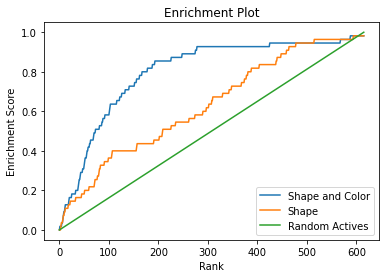

In [132]:
fig1,ax1 = plt.subplots()
ax1.plot(df.index.values.tolist(),df['Scores_SC'],label='Shape and Color')
ax1.plot(df.index.values.tolist(),df['Scores_Shape'],label='Shape')
ax1.plot(df.index.values.tolist(),df['Random Actives'],label='Random Actives')
plt.xlabel("Rank")
plt.ylabel("Enrichment Score")
plt.title("Enrichment Plot")
plt.legend(loc="lower right")
plt.savefig('Enrichment_Plot.pdf')

In [148]:
x_cor = df.index.values.tolist()
norm_x = [x_cors/len(x_cor) for x_cors in x_cor]
auc_SC = metrics.auc(norm_x,df['Scores_SC'])
auc_Shape = metrics.auc(norm_x,df['Scores_Shape'])
print('The AUC for Shape and Color overlays is %.2f and for just shape is %.2f' % (auc_SC,auc_Shape))

The AUC for Shape and Color overlays is 0.80 and for just shape is 0.63


Looking at the AUC from the above enrichment plot and comparing it to the AUC from the null models that utilized molecular weight and ligand shape, tanimoto scores with color and shape outperform, tanimoto scores with shape and they both null models utilized in the paper. This shows that the shape and color are useful in predicting activity in this case. 

### Sorting lists

I mentioned I would give an example of a sorting a list. If I have scores stored in the dictionary `scores_by_name` and I wanted to make a list of names sorted by scores, I could do it this way: 

In [48]:
# Make up a dummy dictionary to sort
scores_by_name = {'a':32, 'b':11, 'c':43}

# Make a list we want to sort
names = list(scores_by_name.keys())

# Define function for sorting
def f(x):
    return scores_by_name[x]

# Sort, print sorted list
sorted_names = sorted( names, key=f )
print(sorted_names)

['b', 'a', 'c']


In reality you will have molecule names, and be sorting them by Tanimoto score. 

### Write your code here

Here, complete your assignment as described above:

## What to submit

For this assignment, please submit via the course website:
- From step 3, structure files for your reference molecule as well as for the best shape overlay onto that structure, with scores. Also submit a sentence or more describing what you found in this section.
- From step 4, Your resulting graph of “enrichment” of actual ligands from the set, with axes and curves labeled, along with this Jupyter notebook which produced it
- In a box below, or a separate document, a brief explanation of how you see the performance of the shape overlay approach, in view of the linked paper on the SAMPL4 challenge. Why does it do well, or poorly, in this case? Does ‘color’ scoring in addition to shape help? Why or why not? How does this compare to the “null” models tested in the paper? 